### Đánh giá hiệu suất của DeepCrack và CrackFormer

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

import torch
from torchvision import transforms

from DeepCrack.codes.model.deepcrack import DeepCrack
from CrackFormerII.CrackFormerII.nets.crackformerII import crackformer

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def load_models():
    deepcrack_model = DeepCrack()
    deepcrack_model.load_state_dict(torch.load("DeepCrack/codes/checkpoints/DeepCrack_CT260_FT1.pth"))
    deepcrack_model.to(device)
    deepcrack_model.eval()
    
    crackformer_model = crackformer()
    crackformer_model.load_state_dict(torch.load("CrackFormerII/CrackFormerII/model/cracktree/crack260.pth"))
    crackformer_model.to(device)
    crackformer_model.eval()
    
    return deepcrack_model, crackformer_model

In [4]:
deepcrack_model, crackformer_model = load_models()

In [5]:
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((512, 512), antialias=True),
        #transforms.Normalize((0, 0, 0), (1.0, 1.0, 1.0))    # Normalize to [0, 1]
    ])
    img = transform(image)
    img = img.unsqueeze(0)  # reshape img from shape of (C, H, W) to (1, C, H, W)
    return img

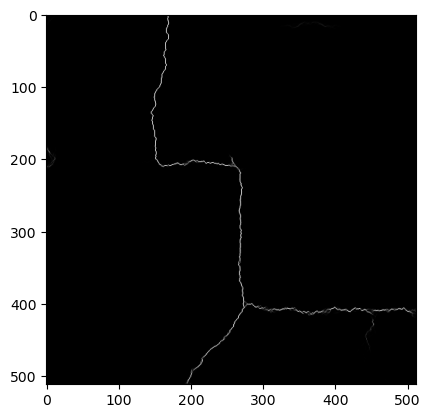

In [6]:
test_img = cv2.imread(r"Datasets\CrackTree260\image\6192.jpg")
test_img = preprocess_image(test_img)
test_img = test_img.to(device)

with torch.no_grad():
    pred = deepcrack_model(test_img)[0]
output = torch.sigmoid(pred)

img_fused = np.squeeze(output.cpu().detach().numpy())
plt.imshow(img_fused, cmap="gray")
plt.show()

In [7]:
images_dir = "Datasets/CRKWH100/image/"
labels_dir = "Datasets/CRKWH100/gt/"

In [13]:
images = sorted(glob(os.path.join(images_dir, "*")))
labels = sorted(glob(os.path.join(labels_dir, "*")))

for imagePath, labelPath in tqdm(zip(images, labels), total=len(images)):
    # Read image and predicts
    image = cv2.imread(imagePath)
    image = preprocess_image(image).to(device)
    with torch.no_grad():
        deepcrack_pred = deepcrack_model(image)[0]
        crackformer_pred = crackformer_model(image)[-1]

    # Read label
    label = cv2.imread(labelPath, cv2.IMREAD_GRAYSCALE) / 255.0
    label = label.astype(np.int32)
    
    print(deepcrack_pred.shape, crackformer_pred.shape, label.shape)
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512]) (512, 512)


  2%|▏         | 2/100 [00:00<00:46,  2.13it/s]

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512]) (512, 512)


  3%|▎         | 3/100 [00:01<00:51,  1.87it/s]

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512]) (512, 512)


  4%|▍         | 4/100 [00:02<00:54,  1.75it/s]

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512]) (512, 512)


  4%|▍         | 4/100 [00:02<01:06,  1.45it/s]


KeyboardInterrupt: 

In [ ]:
label = cv2.imread(r"Datasets\CRKWH100\gt\1000.bmp", cv2.IMREAD_GRAYSCALE) / 255
plt.imshow(label, cmap="gray")
plt.show()

## Đánh giá hiệu suất

In [ ]:
images_dir = "Datasets/CRKWH100/image/"
labels_dir = "Datasets/CRKWH100/gt/"

In [ ]:
# ODS
final_deepcrack_result = []
final_crackformer_result = []
for thresh in np.arange(0.0, 1.0, 0.01):
    print(f"Thresh = {thresh}")
    
    deepcrack_statistics = []
    crackformer_statistics = []
    
    for filename in tqdm(os.listdir(images_dir)):
        imgPath = os.path.join(images_dir, filename)    # path to image
        lblPath = os.path.join(labels_dir, (os.path.splitext(filename)[0] + ".bmp"))    # path to label
        
        img = cv2.imread(imgPath)
        lbl = cv2.imread(lblPath, cv2.IMREAD_GRAYSCALE) / 255   # lbl pixels is 0.0 or 1.0
        
        preprocessed_img = preprocess_image(img).to(device)
        lbl = cv2.resize(lbl, (512, 512))   # Resize label to (512, 512)
        lbl = lbl.astype('uint8')
        
        with torch.no_grad():
            deepcrack_pred = deepcrack_model(preprocessed_img)[0]
            crackformer_pred = crackformer_model(preprocessed_img)[-1]

        deepcrack_predicted_mask = torch.sigmoid(deepcrack_pred.squeeze().cpu()).numpy()
        crackformer_predicted_mask = torch.sigmoid(crackformer_pred.squeeze().cpu()).numpy()
        
        deepcrack_pred_binary = (deepcrack_predicted_mask > thresh).astype('uint8')
        crackformer_pred_binary = (crackformer_predicted_mask > thresh).astype('uint8')
        
        deepcrack_statistics.append(get_statistics(deepcrack_pred_binary, lbl))
        crackformer_statistics.append(get_statistics(crackformer_pred_binary, lbl))
        
    tp_deepcrack = np.sum([s[0] for s in deepcrack_statistics])
    fp_deepcrack = np.sum([s[1] for s in deepcrack_statistics])
    fn_deepcrack = np.sum([s[2] for s in deepcrack_statistics])
    
    precision_deepcrack = 1.0 if tp_deepcrack==0 and fp_deepcrack==0 else tp_deepcrack / (tp_deepcrack + fp_deepcrack)
    recall_deepcrack = tp_deepcrack / (tp_deepcrack + fn_deepcrack)
    f1_score_deepcrack = 2 * precision_deepcrack * recall_deepcrack / (precision_deepcrack + recall_deepcrack)
    final_deepcrack_result.append([thresh, precision_deepcrack, recall_deepcrack, f1_score_deepcrack])
    
    
    tp_crackformer = np.sum([s[0] for s in crackformer_statistics])
    fp_crackformer = np.sum([s[1] for s in crackformer_statistics])
    fn_crackformer = np.sum([s[2] for s in crackformer_statistics])
    precision_crackformer = 1.0 if tp_crackformer==0 and fp_crackformer==0 else tp_crackformer / (tp_crackformer + fp_crackformer)
    recall_crackformer = tp_crackformer / (tp_crackformer + fn_crackformer)
    f1_score_crackformer = 2 * precision_crackformer * recall_crackformer / (precision_crackformer + recall_crackformer)
    final_crackformer_result.append([thresh, precision_crackformer, recall_crackformer, f1_score_crackformer])

In [ ]:
print(f"DeepCrack result: {final_deepcrack_result}")
print(f"CrackFormer result: {final_crackformer_result}")

In [ ]:
final_deepcrack_result = np.array(final_deepcrack_result)
final_crackformer_result = np.array(final_crackformer_result)

In [ ]:
np.savetxt("Results/deepcrack_ods.txt", final_deepcrack_result)
np.savetxt("Results/crackformer_ods.txt", final_crackformer_result)

In [ ]:
print(np.amax(final_deepcrack_result, axis=0))
print(np.amax(final_crackformer_result, axis=0))